# Visualizing Ras Classification Scores by Oncogenicity Status

The Pathway Working Group from TCGA PanCancerAtlas curated variants in Ras Pathway genes by their expert-predicted oncogenicity status (either oncogenic or unconfirmed). Here, we output three sets of files

1. Oncogenicity scores by Ras classifier score dataframe
2. Swarm plots of Ras classifier scores by Oncogenicity status
3. Co-occurence plots of Ras by TP53 and SUZ12 status

In [1]:
import os
import csv
import numpy as np
import pandas as pd
from decimal import Decimal
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
sns.set(style="whitegrid")
sns.set_context("paper", rc={"font.size":14, "axes.titlesize":15, "axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

In [4]:
np.random.seed(123)

In [5]:
def assign_curation(aa_row, df='ras_variant'):
    """
    Determines if the specific amino acid mutation is cataloged as Oncogenic 
    in the Ras pathway or not. To be used as a call to pandas.DataFrame().apply() 
    
    Arguments:
      aa_row - a row that has gene and mutation information
      df - the type of dataframe called, can either be `ras_variant` or `sample`
           depending on the type of dataframe to assign curation
    
    Output:
      Oncogenicity Status for the given amino acid mutation
    """
    gene = aa_row['Hugo_Symbol']
    if df == 'ras_variant':
        aa = aa_row.name
    elif df == 'sample':
        aa = aa_row['HGVSp']
    ras_sub = ras_variant_df[ras_variant_df.index == gene]
    if len(ras_sub) == 0:
        return 'Not Ras'
    
    if aa in ras_sub['mutation'].tolist():
        return 'Oncogenic'
    else:
        return 'Unconfirmed'

In [6]:
# Set File names
aa_mutation_scores_file = os.path.join('..', 'classifiers', 'RAS', 'tables',
                                       'amino_acid_mutation_scores.tsv')
ras_variant_curation_file = os.path.join('..', 'classifiers', 'RAS', 'tables',
                                         'Ras_pathway_variant_oncogenicity_data.tsv')
sample_mutation_scores_file = os.path.join('..', 'classifiers', 'RAS', 'tables',
                                           'mutation_classification_scores.tsv')

# Output Files
aa_out_file = os.path.join('..', 'classifiers', 'RAS', 'tables',
                           'RAS_oncogenecity_predictions.tsv')

In [7]:
# Load Ras variant curation file
ras_variant_df = pd.read_table(ras_variant_curation_file, index_col=0)
ras_variant_df.head(2)

,mutation,gene_type,MutSig,hotspots,copy_number_fusion,GISTIC_amp,GISTIC_del,McCormick
Gene,,,,,,,,
ALK,fusion gene,OG,1,some hotspots & known mutations,fusion gene,NaN,;,yes
ALK,p.Asp1203Tyr,OG,1,some hotspots & known mutations,fusion gene,NaN,;,yes


In [8]:
# Add oncogenecity designation to each amino acid mutation and write to file
aa_scores = pd.read_table(aa_mutation_scores_file, index_col=0)

aa_onco_df = aa_scores.assign(designation = aa_scores.apply(assign_curation, axis=1))
aa_onco_df.to_csv(aa_out_file, sep='\t')

aa_onco_df.head(2)

,Variant_Classification,Hugo_Symbol,Mean,SD,count,low_CI,high_CI,designation
HGVSp,,,,,,,,
p.Val600Glu,Missense_Mutation,BRAF,0.379832,0.222155,453,0.360466,0.401139,Oncogenic
p.Gly12Asp,Missense_Mutation,KRAS,0.819980,0.126311,166,0.800135,0.838195,Oncogenic


In [9]:
# Add curation to specific mutation scores
mut_scores_df = pd.read_table(sample_mutation_scores_file, index_col=0)
mut_scores_df = (
    mut_scores_df[mut_scores_df['Variant_Classification']
                  .isin(['Missense_Mutation', 'Nonsense_Mutation'])]
    )
ras_pathway_scores_df = mut_scores_df[mut_scores_df['Hugo_Symbol'].isin(ras_variant_df.index.tolist())]
ras_pathway_scores_df = (
    ras_pathway_scores_df.assign(
        curation = ras_pathway_scores_df.apply(lambda x:
                                               assign_curation(x, df='sample'), axis=1))
    )
ras_pathway_scores_df.head(2)

,log10_mut,total_status,weight,NRAS,HRAS,KRAS,HRAS_gain,KRAS_gain,NRAS_gain,PATIENT_BARCODE,...,SUBTYPE,hypermutated,include,ID.1,Tumor_Sample_Barcode,Hugo_Symbol,HGVSc,HGVSp,Variant_Classification,curation
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-2485-01,1.748188,0.0,0.467431,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-02-2485,...,IDHwt,0.0,0.0,TCGA-02-2485-01,TCGA-02-2485-01A-01D-1494-08,EGFR,c.866C>A,p.Ala289Asp,Missense_Mutation,Oncogenic
TCGA-04-1362-01,1.838849,0.0,0.484370,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-04-1362,...,Not_Applicable,0.0,1.0,TCGA-04-1362-01,TCGA-04-1362-01A-01W-0492-08,SOS1,c.3691C>G,p.Leu1231Val,Missense_Mutation,Unconfirmed


In [10]:
# Separate out samples with Oncogenic curation status
oncogenic_sample_df = ras_pathway_scores_df[ras_pathway_scores_df['curation'] == 'Oncogenic']
unconfirmed_sample_df = (
    ras_pathway_scores_df[~ras_pathway_scores_df.index.isin(oncogenic_sample_df.index)]
    )

filtered_df = pd.concat([oncogenic_sample_df, unconfirmed_sample_df])

In [11]:
# Generate and Save plots
plt.rcParams['figure.figsize']=(3.5, 4)
t_test_results = []
x1, x2 = 0, 1

for gene in set(mut_scores_df['Hugo_Symbol']):
    gene_mutation_score_df = filtered_df[filtered_df['Hugo_Symbol'] == gene]
    gene_mutation_score_df = gene_mutation_score_df.dropna(axis=0, subset=['weight'])
    fig_name = os.path.join('..', 'figures', 'variants', 'variant_prediction_{}.pdf'.format(gene))
    try:
        # perform an independent t-test for prediction scores by oncogenicity
        oncogenic_scores = (
            gene_mutation_score_df.loc[
                gene_mutation_score_df['curation'] == 'Oncogenic', 'weight']
            )
        unconfirmed_scores = (
            gene_mutation_score_df.loc[
                gene_mutation_score_df['curation'] == 'Unconfirmed', 'weight']
            )

        t_results = ttest_ind(a = oncogenic_scores,
                              b = unconfirmed_scores, equal_var = False)
        add_result = [gene, t_results.pvalue, t_results.statistic]
        t_test_results.append(add_result)
        
        # Setup p value annotation
        max_val = gene_mutation_score_df['weight'].max()
        y, h = max_val + 0.06, 0.05
        
        # Plot
        ax = sns.stripplot(x='curation', y='weight', data=gene_mutation_score_df, 
                           palette = {'Oncogenic': "seagreen", 'Unconfirmed': 'goldenrod'},
                           jitter=0.35, size=3.25, alpha=0.65)
        ax.axes.set_ylim(0, max_val + 0.2)
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, ''])
        ax.set_ylabel('Ras Classifier Score')
        ax.set_xlabel(gene)
        plt.axhline(0.5, color='grey', linestyle='dashed', linewidth=2)
        
        # Only display t-test bars if there are two classes of data
        if len(oncogenic_scores) != 0 and len(unconfirmed_scores) != 0:
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
            plt.text(.5, y+h, "{:.2E}".format(Decimal(t_results.pvalue)),
                     ha='center', va='bottom', color="black")
    
        plt.tight_layout()
        plt.savefig(fig_name)
        plt.close()
    
    except:
        next

/home/gway/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/gway/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Write out full t-test results
t_test_file = os.path.join('..', 'results', 'ras_t_test_oncogenicity.tsv')
with open(t_test_file, 'w') as csvfile:
    onco_writer = csv.writer(csvfile, delimiter='\t')
    onco_writer.writerow(['gene', 'p_value', 't_statistic'])
    for t_ in t_test_results:
        onco_writer.writerow(t_)

## Investigate cooccurrence of Ras mutations with TP53 and SUZ12

In [13]:
mut_file = os.path.join('..', 'data', 'pancan_mutation_freeze.tsv')
classifier_scores_file = os.path.join('..', 'classifiers', 'RAS',
                                      'classifier_decisions.tsv')

mutation_df = pd.read_table(mut_file, index_col=0)
classifier_scores_df = pd.read_table(classifier_scores_file, index_col=0)

In [14]:
genes = ['TP53', 'SUZ12']
y = mutation_df[genes]

In [15]:
plot_df = y.merge(classifier_scores_df, left_index=True, right_index=True)

In [16]:
def plot_ras_score(df, alt_gene):
    ax = sns.boxplot(x="total_status", y="weight", data=plot_df,
                 hue=alt_gene, palette = {0: "whitesmoke", 1: 'gainsboro'},
                 fliersize=0)
    ax = sns.stripplot(x='total_status', y='weight', hue=alt_gene,
                       data=plot_df, 
                       dodge=True, edgecolor='gray',
                       palette = {1: "seagreen", 0: 'goldenrod'},
                       jitter=0.25, size=2, alpha=0.65)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[2:4], ['Wild-Type', 'Mutant'], bbox_to_anchor=(.63, 0.2), loc=2, borderaxespad=0.)
    l.set_title(alt_gene)
    ax.axes.set_ylim(0, 1.3)
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, ''])
    ax.set_xticklabels(['Ras WT', 'Ras Mutant'])
    ax.set_ylabel('Ras Classifier Score')
    ax.set_xlabel('Ras Status')
    ax.legend
    plt.axhline(0.5, color='black', linestyle='dashed', linewidth=1)
    
    # Ras mutant vs. Ras wildtype
    ras_mutant = plot_df[plot_df['total_status'] == 1]
    ras_wt = plot_df[plot_df['total_status'] == 0]

    # Also interested in alt_gene status within Ras mutant samples
    alt_gene_mutant = ras_mutant[ras_mutant[alt_gene] == 1]
    alt_gene_wt = ras_mutant[ras_mutant[alt_gene] == 0]

    # Also interested in alt_gene status within Ras wildtype samples
    alt_gene_mutant_raswt = ras_wt[ras_wt[alt_gene] == 1]
    alt_gene_wt_raswt = ras_wt[ras_wt[alt_gene] == 0]
    
    # Output t-test results
    t_results_ras = ttest_ind(a = ras_mutant['weight'],
                              b = ras_wt['weight'], equal_var = False)

    t_results_alt = ttest_ind(a = alt_gene_mutant['weight'],
                              b = alt_gene_wt['weight'], equal_var = False)
    
    t_results_alt_raswt = ttest_ind(a = alt_gene_mutant_raswt['weight'],
                                    b = alt_gene_wt_raswt['weight'], equal_var = False)
    
    # Add Ras T-Test Results
    plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1.2, c='black')
    plt.text(.5, y1+h, t_results_ras.pvalue,
             ha='center', va='bottom', color="black")

    # Add alt_gene mut t-test results
    plt.plot([x3, x3, x4, x4], [y2, y2+h, y2+h, y2], lw=1.2, c='black')
    plt.text(0, y2+h, "{:.2E}".format(Decimal(t_results_alt_raswt.pvalue)),
             ha='center', va='bottom', color="black")
    
    # Add alt_gene wild-type t-test results
    plt.plot([x5, x5, x6, x6], [y2, y2+h, y2+h, y2], lw=1.2, c='black')
    plt.text(1, y2+h, "{:.2E}".format(Decimal(t_results_alt.pvalue)),
             ha='center', va='bottom', color="black")
    plt.tight_layout()

In [17]:
# Plot Results
x1, x2 = 0, 1
x3, x4 = -0.2, 0.2
x5, x6 = 0.8, 1.2
y1, y2, h = 1.17, 1, 0.03
plt.rcParams['figure.figsize']=(3.5, 4)

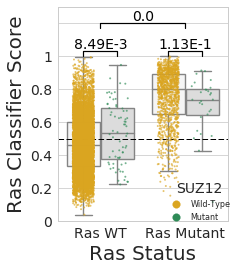

In [18]:
plot_ras_score(plot_df, 'SUZ12')
base_path = os.path.join('..', 'classifiers', 'RAS', 'figures')
fig_file = os.path.join(base_path, 'suz12_cooccurence.png')
plt.savefig(fig_file)

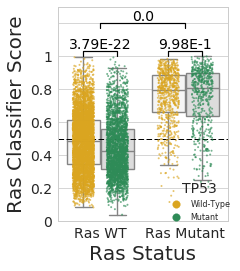

In [19]:
plot_ras_score(plot_df, 'TP53')
fig_file = os.path.join(base_path, 'tp53_cooccurence.png')
plt.savefig(fig_file)